We import some parts from qiskit library and other libraries.

In [31]:
from qiskit import *
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import scipy.optimize as sci
from scipy.interpolate import interp1d as imp
from scipy.stats import linregress as linreg
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram

we get simulators, we now have a quantum simulator, a satevector simulator and a simulator of IBM's cloud quantum machine.

In [32]:
simulator = Aer.get_backend('qasm_simulator')
statecomp = Aer.get_backend('statevector_simulator')
# IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# qcomp= provider.get_backend('ibmq_qasm_simulator')

We now make our bits and basic circuit with measurement of qbit to realise it .

c:\Users\ishaa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


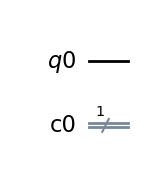

In [33]:
qbit = QuantumRegister(1,name='q0')
cbit = ClassicalRegister(1,name='c0')
qc = QuantumCircuit(qbit,cbit)
qc.draw('mpl')

We simulate our circuit with statevector simulator and present the qbit in bloch sphere.

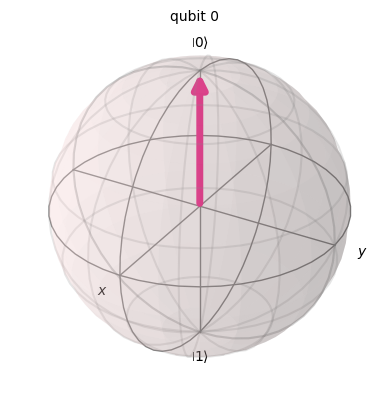

In [34]:
results = execute(qc, backend= statecomp).result()
statevector = results.get_statevector()
plot_bloch_multivector(statevector)

We rotate the qbit by $\theta$ angle along an axis say y-axis and then measure the probability of the statevector in computational basis states $ |0> $ and $|1>$ .
The rotation operator is $e^{-i\sigma_y\frac{\theta}{2}}|0⟩$ 

The probability of measuring the state $|0>$ of this qbit is : 
$$\left|⟨0|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨0|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨0|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \cos^2\left(\frac{\varphi}{2}\right)$$
And porbability of measuring the state $|1>$ is 
$$\left|⟨1|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨1|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨1|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \sin^2\left(\frac{\varphi}{2}\right)$$

We can now change $\theta$ and the difference between the angle when these probability would become their maximum would be a complete opposite rotation that is the angle $\pi$

For this we apply a rotational gate on qbit and rotate the bit intially by an angle 3.14 radian our intial guess of $\pi$. The gate is $R_Y(\theta)$ applied in qiskit using the $U(\theta, 0, 0)$ command that rorate about y-axis by $\theta$.

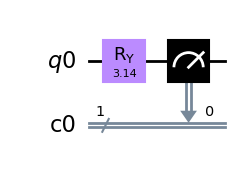

In [35]:
theta = 3.14 

qc.ry(theta,qbit)

qc.measure(qbit, cbit)
qc.draw('mpl')

This gives us the basic gate and measurement application. We apply this multiple times with different values of $\theta$ 

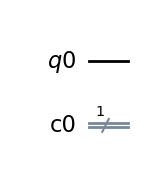

In [36]:
qc = QuantumCircuit(qbit, cbit)
qc.draw('mpl')

In [37]:
n_iter = 200
# range of pi from 3 to 4
rang = [0.1,6.5]
theta = np.linspace(rang[0], rang[1], n_iter)
# list of qtm circuits 
qc_l = []

# all circuits are same with different theta value only
for i in range(n_iter):
    qc_l.append(qc.copy())
    qc_l[i].ry(-theta[i],qbit)
    qc_l[i].measure(qbit, cbit)

We now have 100 seperate circuits with different theta angles, now we simulate these circuits : 

In [38]:
# empty counts list 
counts = []
shot = 10000
for i in range(n_iter):
    job = execute(qc_l[i], backend=simulator, shots= shot)
    counts.append(job.result().get_counts())

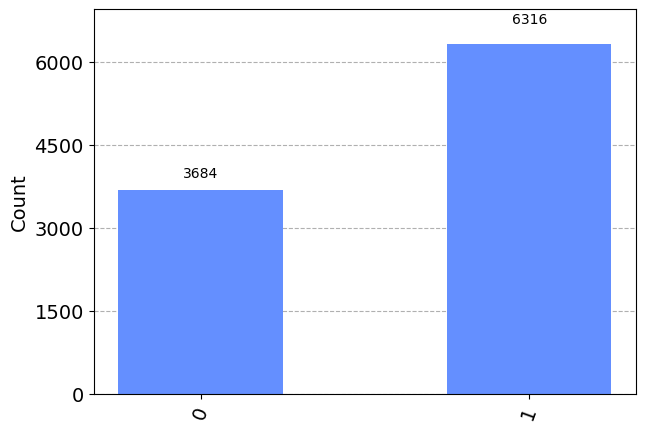

In [39]:
#Plotting a random measurement outcome
plot_histogram(counts[np.random.randint(200)])

Plotting this probability of measuring 1 vs the angle of rotation is : 

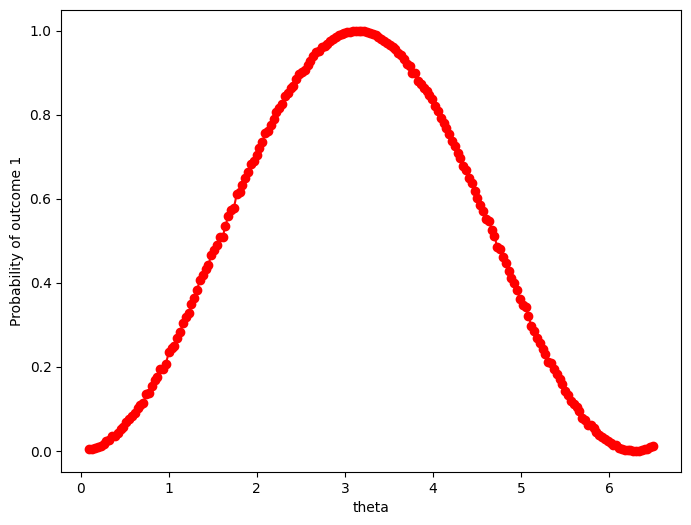

In [40]:
countsOf1 = []
for _ in counts:
    if '1' in _:
        countsOf1.append(_['1']/shot)
    else:
        countsOf1.append(0)

plt.figure(figsize=(8, 6))
plt.plot(theta, countsOf1, 'ro-')
plt.xlabel('theta'); plt.ylabel('Probability of outcome 1')
plt.show()

In [41]:
max_i = countsOf1.index(max(countsOf1))
theta_max = theta[max_i]
print('Maximum probability of 1 occurs at theta (in radians) = ', theta_max)

Maximum probability of 1 occurs at theta (in radians) =  3.155276381909548


Making the whole thing as a single function so as to iterate it multiple times to get maximum $\theta$ for each iteration 

In [42]:
def CalculatePi(simulator,shots,n,rang,plot) -> list :
    qc_l = []
    counts = []
    countsOf1 = []

    qbit = QuantumRegister(1,name='q0')
    cbit = ClassicalRegister(1,name='c0')
    qc = QuantumCircuit(qbit,cbit)
    theta = np.linspace(rang[0],rang[1],n)
    
    for i in range(n):
        qc_l.append(qc.copy())
        qc_l[i].ry(-theta[i],qbit)
        qc_l[i].measure(qbit, cbit)
    
    for i in range(n):
        job = execute(qc_l[i], backend=simulator, shots= shots)
        counts.append(job.result().get_counts())
    
    for _ in counts:
        if '1' in _:
            countsOf1.append(_['1']/shot)
        else:
            countsOf1.append(0)
    
    max_i = countsOf1.index(max(countsOf1))
    theta_max = theta[max_i]

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(theta, countsOf1, 'ro-')
        plt.xlabel('theta')
        plt.ylabel('Probability')
        plt.tight_layout
        plt.show()
        print('maximum at angle :', theta_max)
    
    return theta, countsOf1, theta_max

We now run this function for some iterations get the $\theta$ corresponding to the maximum from all of them then take average and standard deviation for our conclusive data of realised value of $\pi$.

In [43]:
run = 10
pi_s = []
for i in range(run):
    theta, countsOf1, approxpi = CalculatePi(simulator, shots=5000, n=200, rang = [0.1,6.5], plot = False)
    pi_s.append(approxpi)

print('Pi = ', sum(pi_s)/run)
print('Standard deviation in values of pi is : ', st.pstdev(pi_s))

Pi =  3.1263316582914573
Standard deviation in values of pi is :  0.00964824120603014


There can be multiple reasons of error in our experiment from the base intial state of qbit being a 100% $|0>$, rotation along y-axis being acurate and then the measurement error. To mitigate these errors the paper transformes the original parameters as a linear combination of another parameter. Basically they did OLS of each parameter along a realised parameter. The probability of getting 1 after rotation by $\theta$ angle is given by 
$$\left|⟨1|e^{-i\sigma_y\frac{\varphi}{2}}|0⟩\right|^2 = \left|⟨1|\cos\left(\frac{\varphi}{2}\right)|0⟩ + ⟨1|\sin\left(\frac{\varphi}{2}\right)|1⟩\right|^2 = \sin^2\left(\frac{\varphi}{2}\right)$$
$$ \sin^2\left(\frac{\varphi}{2}\right)  = \frac {1-\cos(\varphi)}{2}$$
Probability = $ \frac {1-\cos(\theta)}{2} $ but doing OLS on this probability as well as our intial parameter $\theta$ the fitted probability could be given by 
$$ P(t) = \alpha \frac {1-\cos(ct + \phi)}{2} + \beta$$
we make a new function for this fitted probability as :

In [44]:
def P(t,a,b,c,d):
    return a*(1-np.cos(c*t+d))/2 + b

We take a data 

In [45]:
t, countsOf1, approxpi = CalculatePi(simulator, shots=5000, n=200, rang = [0.1,6.5], plot = False)

And fit it to our function to get intiaL values of our OLS variables.

In [46]:
# curve fit function of scipy library taken here with intial guesses of parameters in p0 and bounds in bounds.
ajust = sci.curve_fit( P, t, countsOf1, p0 = [1., 0., 1., 0.], bounds = ( [-1., -1., -3, -np.pi], [2., 1., 3, np.pi] ) )
a, b, c, d = ajust[0]
# the standard deviation ones 
sa, sb, sc, sd = np.sqrt(np.diag(ajust[1]))

print('The realised values using Ordinary least square error are ')
print('a= ', a, ' +- ', sa)
print('b= ', b, ' +- ', sb)
print('c= ', c, ' +- ', sc)
print('d= ', d, ' +- ', sd)

The realised values using Ordinary least square error are 
a=  0.4994456973527171  +-  0.0005711649709285984
b=  0.0002574649866515516  +-  0.0005184308883108295
c=  1.0002134160945637  +-  0.0012237464911467107
d=  0.0007358515950835939  +-  0.004002218029689979


Plot this realised value w.r.t our plot 

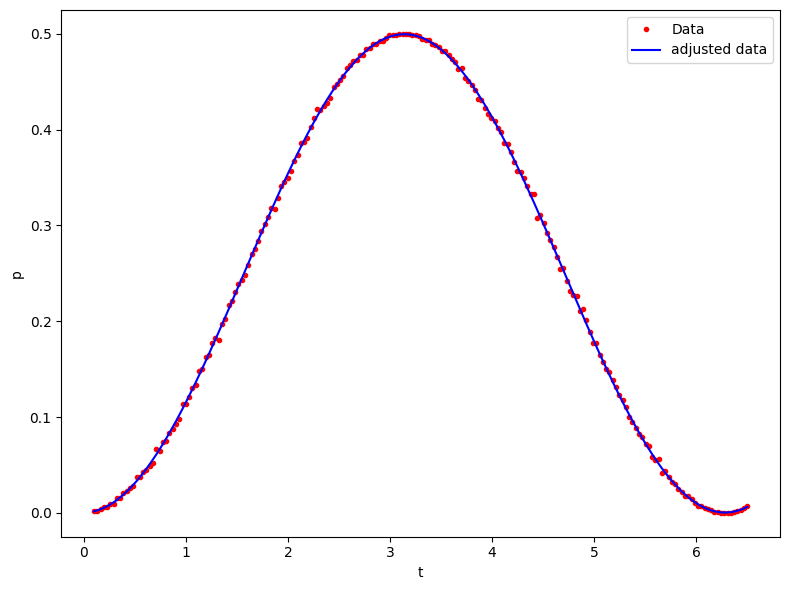

In [47]:
plt.figure(figsize=(8,6))
plt.plot(t, countsOf1, 'r.', label='Data')
plt.plot(t, P(t, a, b, c, d), 'b-', label='adjusted data')
plt.xlabel('t')
plt.ylabel('p')
plt.legend(loc='upper right')
plt.tight_layout() 
plt.show()

getting this equation's 
$$ P(t) = \alpha \frac {1-\cos(ct + \phi)}{2} + \beta$$
the value of fitted $\beta$ and $\alpha$ as 
- $\hat{\beta} = \min_t P(t)$
- $\hat{\alpha} = \max_t P(t) - \hat{\beta}$

In [48]:
bhat = min(countsOf1) 
ahat = max(countsOf1)- bhat
print('beta hat = ', bhat); print('alpha hat = ', ahat)

beta hat =  0
alpha hat =  0.5


Using this data we get the p1($t$) equation as 
$$ p_1(t) = \frac{P(t) - \hat \beta}{\hat \alpha}$$

In [49]:
p1s = ( np.array(countsOf1) - bhat ) / ahat

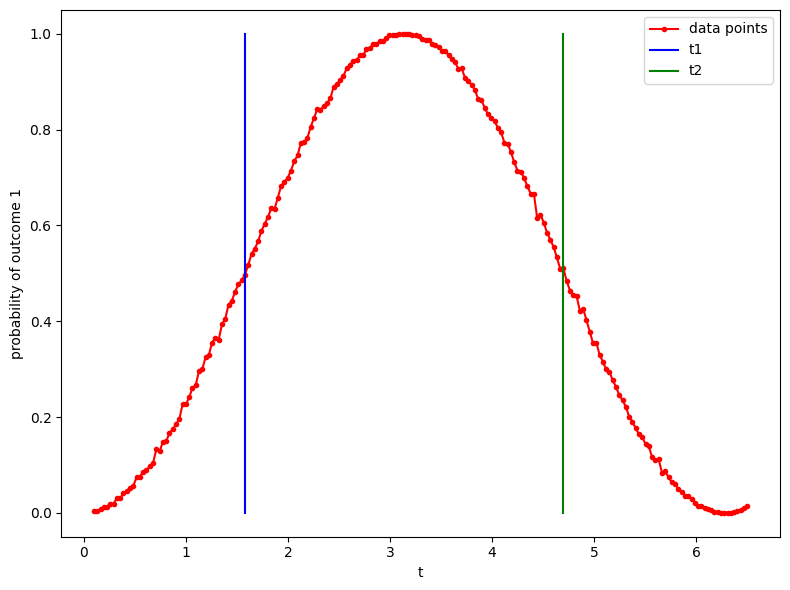

In [50]:
#divide the list in 2 sets from maximum point
t_split = list(p1s).index(max(p1s))
p1s1 = p1s[:t_split]
p1s2 = p1s[t_split:]
#Interpolate the intial counts value and respective t values 
intp1 = imp(p1s1, t[:t_split])
# value of this interpolate at half counts
t1 = intp1(0.5)
intp2 = imp(p1s2, t[t_split:])
t2 = intp2(0.5)
plt.figure(figsize=(8,6))
plt.plot(t, p1s, 'r.-', label='data points')
plt.plot([t1, t1], [0, 1], 'b-', label='t1')
plt.plot([t2, t2], [0, 1], 'g-', label='t2')
plt.xlabel('t'); plt.ylabel('probability of outcome 1')
plt.legend(loc='upper right')
plt.tight_layout(); plt.show()

This $t_1$ and $t_2$ are basically the $\pi/2$ and $3\pi/2$ values.

Now we have $t_1 = t_{min}$ and $t_2 = t_{max}$ we can re-estimate them for local correction as $\hat{\alpha}$ and $\hat{\beta}$ by averaging them over realises values as:
$\left\{\begin{array}{l}\operatorname{mean}\left\{p_{1}(t)\left|t-\hat{t}_{\text{min }}\right|<\delta\right\}=\hat{\beta} \\ \operatorname{mean}\left\{p_{1}(t) \left| t-\hat{t}_{\text {max}}\right|<\delta\right\}=\hat{\alpha}+\hat{\beta}\end{array}\right.$

In [51]:
# Using small delta to estimate 
delta = 0.1; tmax = (t1+t2)/2; tmin = 2 * tmax
# getting index of p1s's which are near to the t1 and t2.
index1 = [ _  for _ in range(n_iter) if abs( t[_] - tmin ) < delta ]
index2 = [ _  for _ in range(n_iter) if abs( t[_] - tmax ) < delta ]
# a and b using this t1 and t2 nearby averaging them for local values
b = sum(p1s[index1])/len(index1)
a = sum(p1s[index2])/len(index2) - b

print('a = ', a); print('b = ', b)

a =  0.9981142857142857
b =  0.0010857142857142856


In [52]:
p2s = ( np.array(p1s) - b ) / a

Now we perform linear regression on them in local sperately for t1 and t2 to get them where we state the equation of graph is 
$$ LR(p(t)) = kt + \gamma $$ 
for the value of p(t) = 0.5 (at $\pi/2$ and $3\pi/2$) from t1 and t2 we get  
$$ t_{1,2} = \frac{0.5 - k_{1,2}}{\gamma_{1,2}}

In [53]:
#Filtering index no father than 0.5 from the points of t1 and t2
index1 = [ _  for _ in range(n_iter) if abs( t[_] - t1 ) < 0.5 ]
index2 = [ _  for _ in range(n_iter) if abs( t[_] - t2 ) < 0.5 ]

#Adjusting the parameters
result1 = linreg(t[index1], p2s[index1], alternative='less')
k1, gamma1 = result1.intercept, result1.slope

result2 = linreg(t[index2], p2s[index2], alternative='greater')
k2, gamma2 = result2.intercept, result2.slope

#Obtenemos los t
t1 = (0.5 - k1) / gamma1 
t2 = (0.5 - k2) / gamma2

Plotting this new t1 and t2 we got from linear regressions for value 0.5 .

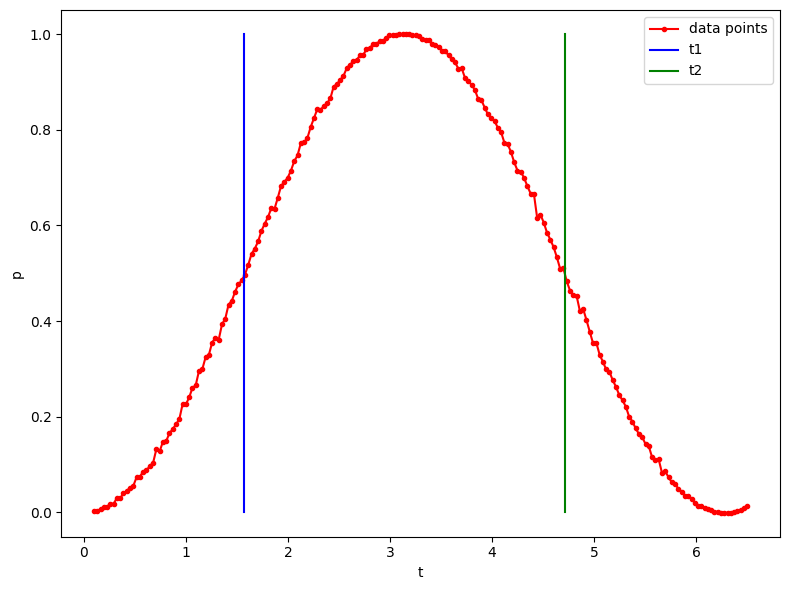

In [54]:
plt.figure(figsize=(8,6))
plt.plot(t, p2s, 'r.-', label='data points')
plt.plot([t1, t1], [0, 1], 'b-', label='t1')
plt.plot([t2, t2], [0, 1], 'g-', label='t2')
plt.xlabel('t'); plt.ylabel('p')
plt.legend(loc='upper right')
plt.tight_layout(); plt.show()

Now we only have to do the integral I = $\int^{t_2}_{t_1}\left(p(t)-\frac{1}{2}\right) dt$ 
we won't be able to integrate using only line equation and the points t1 and t2 (we can if we use inbuilt integral from numpy library but we are using trapezoid intergral method)

In [55]:
I = 0.0
interp = imp(t, p2s)
#No of points for integration
n_integral = 100

deltaT = (t2-t1)/n_integral

#trapeziod integrations with delta t 
for _ in range(n_integral): I += (interp(t1+_*deltaT)-0.5)
I *= deltaT

print('Integral = ', I)

Integral =  0.9991168991044628


Pi now would be given as 
$$ \pi = \frac {t_2 - t_1}{\int_{t_1}^{t_2} (p(t) - \frac 1 2) dt}

In [56]:
pi = (t2 - t1) / I
print('pi = ', pi)

pi =  3.1434389319442024


Making a function out this this complete since the creation of our t, counts,max t giving function to simulate multiple iterations to get different values of $\pi$ each time. This function takes in the no. of values you want between your range of angle, the counts how many times you want the experiment to occur for each angle,and the angle of maximum count1.

In [57]:
def GetPi(t, countsOf1,t_max, n_iter) -> float:
    # using min and max value of CountsOf1 to get bhat and ahat
    bhat = min(countsOf1) ; ahat = max(countsOf1)- bhat
    p1s = ( np.array(countsOf1) - bhat ) / ahat
    #splitting the list into two 
    t_split = list(p1s).index(max(p1s))
    counts21 = p1s[:t_split]; counts22 = p1s[t_split:]
    interp1 = imp(counts21, t[:t_split]); t1 = interp1(0.5)
    interp2 = imp(counts22, t[t_split:]); t2 = interp2(0.5)
    # applying out intial assumption values that is ahat and bhat
    delta = 0.1; tmax = (t1+t2)/2; tmin = 2 * tmax
    index1 = [ _  for _ in range(n_iter) if abs( t[_] - tmin ) < delta ]
    index2 = [ _  for _ in range(n_iter) if abs( t[_] - tmax ) < delta ]
    bhat = sum(p1s[index1])/len(index1)
    ahat = sum(p1s[index2])/len(index2) - bhat

    p2s = ( np.array(p1s) - bhat ) / ahat
    # applying linear regression again on p2s this time for our internal parameter t as theta = ct + phi
    index1 = [ _  for _ in range(n_iter) if abs( t[_] - t1 ) < 0.5 ]
    index2 = [ _  for _ in range(n_iter) if abs( t[_] - t2 ) < 0.5 ]

    result1 = linreg(t[index1], p2s[index1], alternative='less')
    k1, gamma1 = result1.intercept, result1.slope
    result2 = linreg(t[index2], p2s[index2], alternative='greater')
    k2, gamma2 = result2.intercept, result2.slope

    t1 = (0.5 - k1) / gamma1; t2 = (0.5 - k2) / gamma2
    # getting integral of our linear regressed models 
    I = 0.0; interp = imp(t, p2s)
    n_integral = 100; deltaT = (t2-t1)/n_integral
    for _ in range(n_integral): I += (interp(t1+_*deltaT)-0.5)
    I *= deltaT; pi = (t2 - t1) / I

    return pi

Running this function n times to get $<\pi>$

In [58]:
runs = 10
pi_s = []
for i in range(runs):
    t, counts1, t_max = CalculatePi(simulator, shot, n_iter, rang, plot = False)
    pi_s.append(GetPi(t, counts1, t_max, n_iter))

print('Pi = ', sum(pi_s)/runs)
print("Standard deviation in measuring pi = ", st.pstdev(pi_s) )

Pi =  3.1382194332189024
Standard deviation in measuring pi =  0.0028557140150180143


Thus the value of pi is 

In [59]:
print(" Pi = ", np.round( sum(pi_s)/runs, 6) , ' +- ', np.round(st.pstdev(pi_s), 6))

 Pi =  3.138219  +-  0.002856


To use IBM's quantum computer for the result the code is below :
Note only run if you dare to use up resources cause even value of pi being calculates is easily 16 decimals but IBM's cloud only provide limited resources so it goes out of limit sometimes.

In [61]:
from qiskit import IBMQ
# IBMQ.save_account('Your API Tocken in single quotes')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp= provider.get_backend('ibm_perth')

runs = 1
pi_s = []
for i in range(runs):
    t, counts1, t_max = CalculatePi(simulator = qcomp, shots = 4000, n = 100, rang = [0.1,6.5], plot = False)
    pi_s.append(GetPi(t, counts1, t_max, n_iter))

print('Pi = ', sum(pi_s)/runs)
print("Standard deviation in measuring pi = ", st.pstdev(pi_s) )

ibmqfactory.load_account:WARNING:2023-11-17 22:16:31,957: Credentials are already in use. The existing account in the session will be replaced.
